In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [3]:
# 공개 데이터셋에서 학습 데이터를 내려받습니다.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

C:\Users\CPB06GameN\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
batch_size = 64

# 데이터로더를 생성합니다.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# 모델을 정의합니다.
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [7]:
def train(dataloader, model, loss_fn, optimizer): 
    size = len(dataloader.dataset)
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        
        pred = model(x)
        loss = loss_fn(pred, y)
        
        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f'loss:{loss:>7f} [{current:>5d}/{size:>5d}]')

In [8]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
            

In [9]:
epochs = 5
for t in range(epochs):
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print('끝~~')

loss:2.304038 [    0/60000]
loss:2.295921 [ 6400/60000]
loss:2.281278 [12800/60000]
loss:2.277195 [19200/60000]
loss:2.266146 [25600/60000]
loss:2.259268 [32000/60000]
loss:2.244255 [38400/60000]
loss:2.233768 [44800/60000]
loss:2.251768 [51200/60000]
loss:2.212995 [57600/60000]
Test Error: 
 Accuracy: 41.2%, Avg loss: 2.213447 

loss:2.237607 [    0/60000]
loss:2.224231 [ 6400/60000]
loss:2.187030 [12800/60000]
loss:2.181524 [19200/60000]
loss:2.147791 [25600/60000]
loss:2.164179 [32000/60000]
loss:2.119767 [38400/60000]
loss:2.110946 [44800/60000]
loss:2.167007 [51200/60000]
loss:2.069714 [57600/60000]
Test Error: 
 Accuracy: 45.1%, Avg loss: 2.082917 

loss:2.144370 [    0/60000]
loss:2.112504 [ 6400/60000]
loss:2.042866 [12800/60000]
loss:2.030642 [19200/60000]
loss:1.957732 [25600/60000]
loss:2.020005 [32000/60000]
loss:1.928699 [38400/60000]
loss:1.929646 [44800/60000]
loss:2.045850 [51200/60000]
loss:1.865660 [57600/60000]
Test Error: 
 Accuracy: 45.6%, Avg loss: 1.904234 

loss

모델 저장하기

In [10]:
torch.save(model.state_dict(), 'model.pth')
print('saved pytorch model state to model.pth')

saved pytorch model state to model.pth


모델 불러오기

In [11]:
model = NeuralNetwork()
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [12]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


In [13]:
import torch
import numpy as np

In [14]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

In [15]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

In [16]:
x_ones = torch.ones_like(x_data)
print(f'ones Tensor: \n {x_ones} \n')

ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 



In [17]:
x_rand = torch.rand_like(x_data, dtype=torch.float)
print(f'random tensor: \n {x_rand} \n')

random tensor: 
 tensor([[0.0315, 0.1254],
        [0.0341, 0.3651]]) 



In [18]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")

Shape of tensor: torch.Size([3, 4])


In [19]:
t1 = torch.cat([tensor, tensor], dim=1)
print(t1)

tensor([[0.2804, 0.2335, 0.7680, 0.5617, 0.2804, 0.2335, 0.7680, 0.5617],
        [0.7906, 0.4021, 0.9558, 0.8370, 0.7906, 0.4021, 0.9558, 0.8370],
        [0.2545, 0.3962, 0.9126, 0.3966, 0.2545, 0.3962, 0.9126, 0.3966]])


In [20]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data", # 학습/ 테스트 데이터가 저장되는 경로입니다.
    train=True, # 데이터셋 여부를 지정
    download=True, # 루트에 데이터가 없는 경우 인터넷에서 다운로드
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

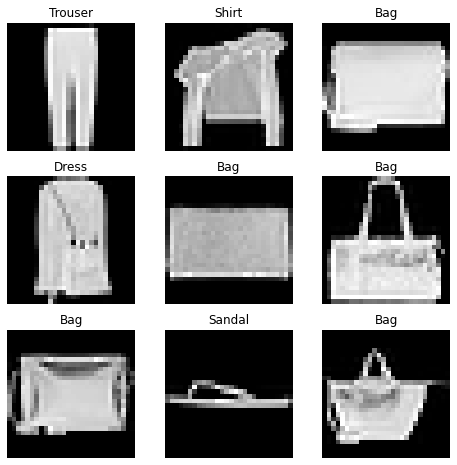

In [21]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [22]:
import os
import pandas as pd
from torchvision.io import read_image

In [23]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None,
                target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.transform = transform
        self.target_transform = target_transform
    
    # 데이터셋의 샘플 개수를 반환
    def __len__(self):
        return len(self.img_labels)
        
    def __getitem__(self, idx):
        # 이미지
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        #이미지와 라벨 정의?
        image = read_image(img_path) # 이미지를 텐서로 변환
        label = self.img_labels.iloc[idx, 1] # 해당 정답을 가져옴
        # 이미지 변형을 지정함
        if self.transform:
            image = self.transform(image)
        # 정답 변형을 지정함
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
     #  텐서 이미지와 라벨을 Python 사전(dict)형으로 반환

In [24]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

특징 배치 shape: torch.Size([64, 1, 28, 28])
labels batch shape : torch.Size([64])


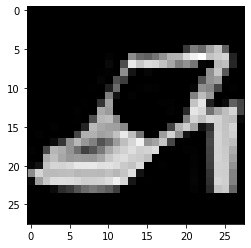

label : 5


In [29]:
train_features, train_labels = next(iter(train_dataloader))
print(f"특징 배치 shape: {train_features.size()}")
print(f'labels batch shape : {train_labels.size()}')

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f'label : {label}')